In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree

In [76]:
class Car(object):
    def __init__(self):
        self.track = pd.read_csv('track.txt',sep=' ')
        self.kdtree = KDTree(self.track)
        self.__reset__()

    def __reset__(self):
        self.max_steering_deg = 25
        self.min_steering_deg = -25
        self.min_speed = 0 #meter per second
        self.max_speed = 50 #meter per second
        self.speed = 0 #meter per second
        self.steering_deg = 0 #degree
        self.heading_deg = 0 #degrees
        self.x = self.track.x[0]
        self.y = self.track.y[0]
        self.length = 1.0 # length of vehicle in meter
        self.trip_length = 0.0 #meters
        
    def render(self):
        plt.figure(figsize=(12,8))
        plt.scatter(self.track.x, self.track.y)
        plt.plot(self.x, self.y, 'ro', markersize=12)
        plt.show()
        
    
    def _to_rad_(deg):
        return deg * np.pi / 180
    
    def _to_deg_(rad):
        return rad*180/np.pi
    
    def __check_off_track__(self):
        dist, ind = self.kdtree.query([[self.x, self.y]], 1)
        car = (round(self.x,2), round(self.y,2))
        closest_x = float(self.track.x[ind[0]])
        closest_y = float(self.track.y[ind[0]])
        closest = (round(closest_x,2),round(closest_y,2))
        assert dist <= 10,\
        f"Game Over!! Your car veered off the track after {self.trip_length}m! Car:{car} Closest Point:{closest}"
    
    def move(self, time_step):
        heading = Car._to_rad_(self.heading_deg)
        steering = Car._to_rad_(self.steering_deg)
        
        delta_x = self.speed*np.cos(heading)*time_step
        delta_y = self.speed*np.sin(heading)*time_step
        self.x = self.x + delta_x
        self.y = self.y + delta_y
     
        new_heading = (heading + self.speed / self.length * steering * time_step) % (np.pi * 2)
        self.heading_deg = Car._to_deg_(new_heading)
        
        self.trip_length += np.sqrt(delta_x**2 + delta_y**2)
        
        self.__check_off_track__()
    
        
    
    def set_steering(self, steer_deg):
        assert self.min_steering_deg <= steer_deg <= self.max_steering_deg,\
        f'Steering angle must be in degree and in the range {self.min_steering_deg},{self.max_steering_deg}'
        
        self.steering_deg = steer_deg
        
        
    def set_speed(self, speed_meter_sec):
        assert self.min_speed <= speed_meter_sec <= self.max_speed,\
        (f'Speed must be in meters per second and in the range {self.min_speed},{self.max_speed}')
        
        self.speed = speed_meter_sec
        
        
    
    def find_nearest_track_points(self,n=5):
        dist, inds = self.kdtree.query([[self.x, self.y]], n)
        inds = list(*inds)
        return self.track.loc[inds]
        

In [77]:
car = Car()

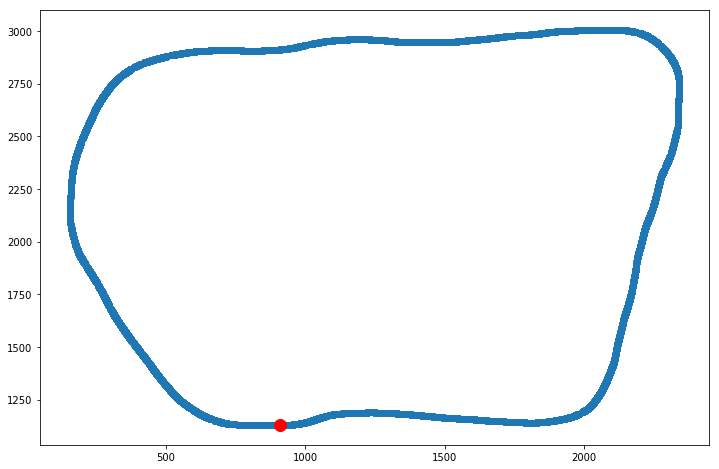

In [78]:
car.render()

57 steps.
Game Over!! Your car veered off the track after 116.0m! Car:(1024.91, 1140.34) Closest Point:(1020.88, 1149.56)


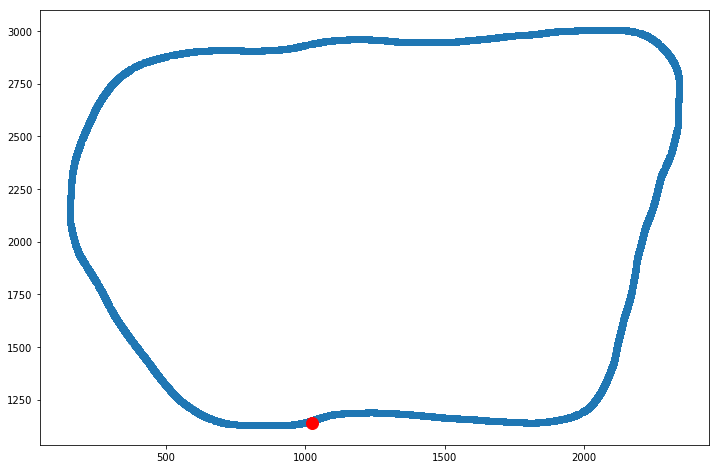

In [79]:
car.__reset__()
car.set_speed(20)
car.set_steering(0.1)

try:
    for i in range(150):
        car.move(.1)
except Exception as err:
    print(f'{i} steps.')
    print(err)
finally:
    car.render()

In [100]:
Kp=0.01
Kd=0.05
Ki=0.005

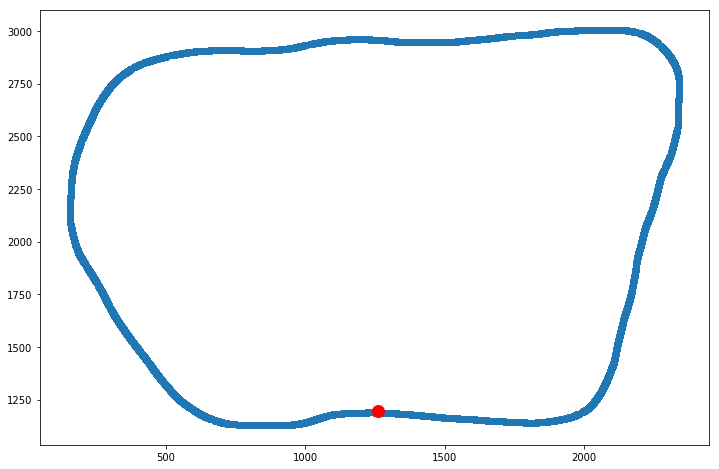

In [101]:
car.__reset__()
car.set_speed(20)
car.set_steering(0.1)

trajectory = []
controls = []
prev_error = 0

try:
    for i in range(300):
        nearest = car.find_nearest_track_points()
        coeffs = np.polyfit(nearest.x, nearest.y, 1)
        desired_heading = Car._to_deg_(np.arctan(coeffs[0]))
        current_heading = car.heading_deg
        
        error = current_heading - desired_heading
        new_steering_degree = car.steering_deg - Kp*error -Kd*(error - prev_error)
        prev_error = error
        if new_steering_degree > car.max_steering_deg:
            new_steering_degree = car.max_steering_deg
        elif new_steering_degree < car.min_steering_deg:
            new_steering_degree = car.min_steering_deg
                
        car.set_steering(new_steering_degree)
        trajectory.append((car.x,car.y))
        controls.append(new_steering_degree)
        car.move(.1)
        
        
except Exception as err:
    print(f'{i} steps.')
    print(err)
finally:
    car.render()

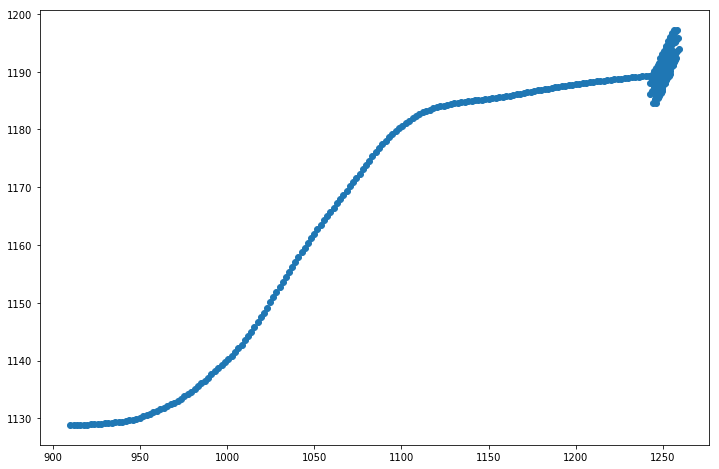

In [102]:
plt.figure(figsize=(12,8))
plt.scatter(*list(zip(*trajectory)))
plt.show()

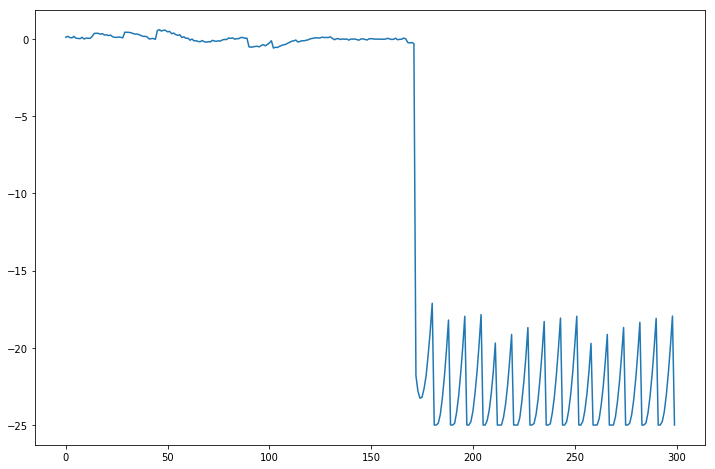

In [103]:
plt.figure(figsize=(12,8))
plt.plot(controls)
plt.show()